## 2. An overview of data heterogeneity
---

Data heterogeneity has been extensively investigated and characterized in statistics and other fields. Here we want to start with a quick overview of the flavours that come to light in FL:

- **Feature distribution skew**
- **Label distribution skew**
- **Quantity skew**
- _Same label, different features_
- _Same features, different label_
- _Violation of Independence_
- _Dataset Shift_

During this lab we will get into more detail about the first three categories only---those bolded.

It is crucial to say that a naturally partitioned dataset, also referred to as a "real FL dataset”, usually presents a combination of more than one of these properties. This enforces developers to take into account **all of these** during the building of the FL pipeline because in real settings **we cannot see or touch data**. I like to exemplify such a situation using a metaphor: data in FL are like a Schroedinger's cat for which we cannot open the cage. Before looking into the details of these flavours, let's install and load some useful packages.


In [1]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
# ! pip install --quiet --upgrade "pip"
# ! pip install --quiet matplotlib tqdm seaborn
# ! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
#     torch torchvision ray=="2.6.3"
# # The following is just needed to show the folder tree
# ! apt-get install -qq tree

In [2]:
import sys
sys.path.append('../../')
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dawn/venvs/fed/lib/python3.10/site-packages', '/home/dawn/repos/cycle-consistent-model-merging/src', '../../']


In [3]:
import sys
import shutil
import random
import tarfile
from collections.abc import Callable
from copy import deepcopy
from pathlib import Path
from typing import Any, ClassVar
from types import MethodType
from logging import INFO

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np

from c2m3.flower.fed_frank_wolfe_strategy import FrankWolfeSync


import seaborn as sns
import pandas as pd
import torch
from torch import nn
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server import ServerConfig, History
from flwr.server.strategy import FedAvg, Strategy
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from flwr.client import Client
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes, parameters_to_ndarrays

from c2m3.common.femnist_dataset import FEMNIST
from c2m3.common.client_utils import (
    to_tensor_transform,
    get_network_generator_mlp,
    get_network_generator_cnn,
    get_model_parameters,
    get_federated_evaluation_function,
    aggregate_weighted_average,
    get_device,
    save_history,
)
from c2m3.common.lda_utils import create_lda_partitions
from c2m3.common.client import FlowerClient, get_frank_flower_client_generator


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


def fit_client_seeded(
    client: FlowerClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

PathType = Path | str | None

2025-03-08 22:59:05.447478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 22:59:05.578732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 22:59:05.579670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 22:59:06.482462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dawn/venvs/fed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-08 22:59:08,401	INFO util.py:

Another important ingredient, necessary to analyse heterogeneity, is a labelled dataset. We will use FEMNIST since we are all familiar with it now. We will initially load the same version of the dataset used in the previous lab, then we will start creating partitions at will.


In [4]:
home_dir = Path.cwd() / ".."
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

In [5]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

We also need the dataset object. We will use the same as in the previous lab.


### 2.1 Feature distribution skew
---

Statisticians and data scientists refer to this property as "covariate shift”. It happens when different clients present samples which describe ideally the same objects having slightly different features. That is the case for two different writers hand-writing the same word, since these may have different stroke widths, slants, etc.
What happens to an FL setting in which this property is strong is not always predictable. Ideally, the global model, obtained using FedAvg, will try to learn a shared representation between clients. This could be problematic since clients have different features to represent their data. We could simply expect that the same seed model trained separately on local clients may perform better than a global model obtained in an FL training.

To see this property in our chosen dataset we will show two images for the same number taken from different clients.
_NOTE: the choice of clients and samples in the following is not random, but suitably made to show you the property._


INFO flwr 2025-03-08 22:59:13,358 | 2179019995.py:10 | For client 0, sample 4 has label 24


2025-03-08 22:59:13 INFO     For client 0, sample 4 has label 24                                            ]8;id=614242;file:///tmp/ipykernel_602100/2179019995.py\flwr]8;;\:]8;id=767447;file:///tmp/ipykernel_602100/2179019995.py#10\10]8;;\

INFO flwr 2025-03-08 22:59:13,366 | 2179019995.py:11 | For client 1000, sample 0 has label 24


                    INFO     For client 1000, sample 0 has label 24                                         ]8;id=665713;file:///tmp/ipykernel_602100/2179019995.py\flwr]8;;\:]8;id=827969;file:///tmp/ipykernel_602100/2179019995.py#11\11]8;;\

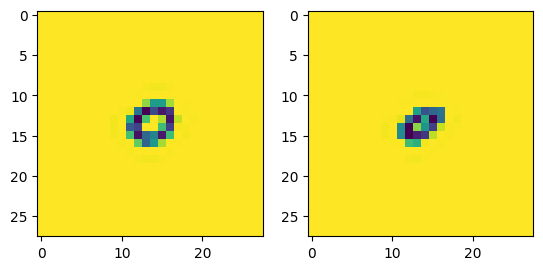

In [6]:
client_0_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "0", data_dir=data_dir, name="train"
)
client_1000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "1000", data_dir=data_dir, name="train"
)
img_a, label_a = client_0_dataset[4]
img_b, label_b = client_1000_dataset[0]

log(INFO, f"For client 0, sample 4 has label {label_a}")
log(INFO, f"For client 1000, sample 0 has label {label_b}")
# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_a)
ax[1].imshow(img_b)

We can also compare the average values of all the features for all the samples of these clients having the label chosen. You can try to execute the cell below choosing different labels.


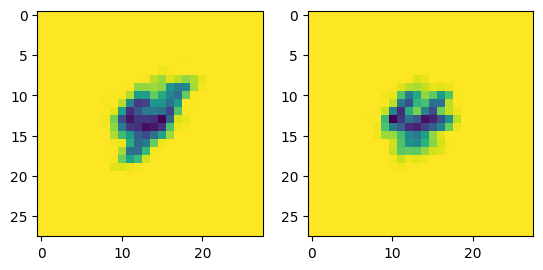

In [7]:
label_chosen = 4
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

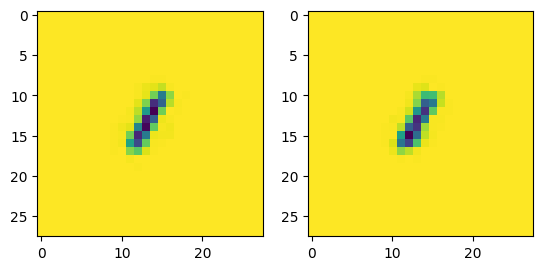

In [8]:
label_chosen = 1
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

It is worth having a glance on what are the consequences of this property on an FL experiment. To do that we will re-use the code for training an FL client from the previous lab.

In order to show on a small scale what can happen to FL training setups where clients have feature distribution skew, we will now build two toy settings. We choose the most populated client---the one with the most samples in the federation. We will then construct a second version of this same client by artificially changing its features by inverting the underlying images--- transforming each image into its negative. Furthermore, we need a specific `get_flower_client_generator` able to invert the images of a specific client.

In the following, we provide the relevant methods to do that. These methods are simplified taking advantage of the federation being composed of just two clients.


In [9]:
from c2m3.flower.frank_flower_client import FrankFlowerClient


def load_femnist_inverted_dataset(mapping: Path, name: str) -> Dataset:
    """Load the filtered FEMNIST dataset given the mapping .csv file.

    The relevant transforms are automatically applied.
    Note that the last transform will invert images, getting their negative
    representation.

    Parameters
    ----------
        mapping (Path): path to the mapping .csv file chosen.
        name (str): name of the dataset to load, train or test.

    Returns
    -------
        Dataset: FEMNIST dataset object, ready to use.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.transforms.F.invert,
    ])

    return FEMNIST(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform,
    )


# NOTE: We need the self to use this for replacing an internal of a class
def _load_inverted_dataset(self: FlowerClient, name: str) -> Dataset:
    """
    Load an inverted dataset for a specific client.

    This function loads the FEMNIST inverted dataset for the client identified by
    `self.cid`. The dataset is loaded from the partition directory specified by
    `self.partition_dir`.

    Parameters
    ----------
        name (str): The name of the dataset to load.

    Returns
    -------
        Dataset: The loaded inverted dataset.

    Raises
    ------
        FileNotFoundError: If the dataset file does not exist.
    """
    full_file: Path = self.partition_dir / str(self.cid)
    return load_femnist_inverted_dataset(mapping=full_file, name=name)


def get_mod_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerClient]:
    """Wrap the function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.
    Note that the "even" clients here will have a modified `_load_dataset` function.
    The new `_load_dataset` has been chosen to be the one inverting the images.

    Parameters
    ----------
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        actual_cid = mapping_fn(int(cid)) if mapping_fn is not None else int(cid)
        client = FrankFlowerClient(
            cid=actual_cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following two lines
        if int(cid) % 2 == 0:
            client._load_dataset = MethodType(_load_inverted_dataset, client)
        return client

    return client_fn

We will now try to train separately the two clients generated this way. The mapping function will be provided to point both client IDs to the data of the most populated client.

```python
mapping_dict = {0: '178', 1: '178'}
```

_NOTE: you may want *to experiment \_with \_different\_\_ clients here*. After having completed the lab, feel free to try!_

The following cell will set the relevant configuration for both training and testing of the client and its inverted version.

> **IMPORTANT: The architecture used here is an MLP because it is affected by inversion of images. Also, note that we must seed the model parameters here.**


In [10]:
# Seed the model
torch.manual_seed(Seeds.DEFAULT)
network_generator_mlp = get_network_generator_mlp()
seed_net_mlp = network_generator_mlp()
seed_model_mlp_params: NDArrays = get_model_parameters(seed_net_mlp)
# Set up config for both train and eval
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": None,
}
# Here is the mapping
mapping_dict = {0: "178", 1: "178"}
# NOTE: we are using here the `get_mod_flower_client_generator`
federated_mod_flower_client_generator: Callable[[str], FlowerClient] = (
    get_mod_flower_client_generator(
        model_generator=network_generator_mlp,
        data_dir=data_dir,
        partition_dir=federated_partition,
        mapping_fn=lambda x: int(mapping_dict[x]),
    )
)
# NOTE: we are using here the `get_flower_client_generator`
federated_flower_client_generator: Callable[[str], FlowerClient] = (
    get_frank_flower_client_generator(
        model_generator=network_generator_mlp,
        data_dir=data_dir,
        partition_dir=federated_partition,
        mapping_fn=lambda x: int(mapping_dict[x]),
    )
)

Let's train separately the two versions of the client and then mutually evaluate their models.


In [11]:
# Create clients
client_0 = federated_mod_flower_client_generator(str(0))
client_1 = federated_mod_flower_client_generator(str(1))
# Fit client 0
client_0_params, *rest = fit_client_seeded(
    client_0, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 0:\n\t{rest}")
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Fit client 1
client_1_params, *rest = fit_client_seeded(
    client_1, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 1:\n\t{rest}")
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 1:\n\t%s",
    client_1_res,
)
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 1:\n\t%s",
    client_1_res,
)

INFO flwr 2025-03-08 22:59:14,129 | 540151065.py:97 | Getting client with id 0


2025-03-08 22:59:14 INFO     Getting client with id 0                                                       ]8;id=798528;file:///tmp/ipykernel_602100/540151065.py\flwr]8;;\:]8;id=688156;file:///tmp/ipykernel_602100/540151065.py#97\97]8;;\

INFO flwr 2025-03-08 22:59:14,133 | frank_flower_client.py:40 | cid: 178


                    INFO     cid: 178                                                                       ]8;id=666052;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=418108;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 22:59:14,140 | 540151065.py:97 | Getting client with id 1


                    INFO     Getting client with id 1                                                       ]8;id=700576;file:///tmp/ipykernel_602100/540151065.py\flwr]8;;\:]8;id=365011;file:///tmp/ipykernel_602100/540151065.py#97\97]8;;\

INFO flwr 2025-03-08 22:59:14,144 | frank_flower_client.py:40 | cid: 178


                    INFO     cid: 178                                                                       ]8;id=773371;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=838929;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/fed_natural'), 'cid': 178, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5904cd30>}


INFO flwr 2025-03-08 22:59:15,855 | 1832891730.py:8 | Results of fitting the seed model on client 0:
	[13, {'train_loss': 0.012169109406666113}]


2025-03-08 22:59:15 INFO     Results of fitting the seed model on client 0:                                  ]8;id=614242;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=767447;file:///tmp/ipykernel_602100/1832891730.py#8\8]8;;\
                                     [13, {'train_loss': 0.012169109406666113}]                                    

100%|██████████| 2/2 [00:00<00:00, 85.73it/s]
INFO flwr 2025-03-08 22:59:15,890 | 1832891730.py:11 | Results of model eval trained on client 0 on the test set of client 0:
	(3.6597142219543457, 2, {'local_accuracy': 0.6808510638297872})


                    INFO     Results of model eval trained on client 0 on the test set of client 0:         ]8;id=665713;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=827969;file:///tmp/ipykernel_602100/1832891730.py#11\11]8;;\
                                     (3.6597142219543457, 2, {'local_accuracy': 0.6808510638297872})               

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/fed_natural'), 'cid': 178, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5904d480>}


INFO flwr 2025-03-08 22:59:17,351 | 1832891730.py:20 | Results of fitting the seed model on client 1:
	[13, {'train_loss': 0.10809687410409634}]


2025-03-08 22:59:17 INFO     Results of fitting the seed model on client 1:                                 ]8;id=598714;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=614242;file:///tmp/ipykernel_602100/1832891730.py#20\20]8;;\
                                     [13, {'train_loss': 0.10809687410409634}]                                     

100%|██████████| 2/2 [00:00<00:00, 155.55it/s]
INFO flwr 2025-03-08 22:59:17,375 | 1832891730.py:23 | Results of model eval trained on client 1 on the test set of client 1:
	(7.188218832015991, 2, {'local_accuracy': 0.2127659574468085})


                    INFO     Results of model eval trained on client 1 on the test set of client 1:         ]8;id=402343;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=665713;file:///tmp/ipykernel_602100/1832891730.py#23\23]8;;\
                                     (7.188218832015991, 2, {'local_accuracy': 0.2127659574468085})                

100%|██████████| 2/2 [00:00<00:00, 158.13it/s]
INFO flwr 2025-03-08 22:59:17,397 | 1832891730.py:30 | Results of model eval trained on client 1 on the test set of client 0:
	(7.9663002490997314, 2, {'local_accuracy': 0.06382978723404255})


                    INFO     Results of model eval trained on client 1 on the test set of client 0:         ]8;id=730983;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=214901;file:///tmp/ipykernel_602100/1832891730.py#30\30]8;;\
                                     (7.9663002490997314, 2, {'local_accuracy': 0.06382978723404255})              

100%|██████████| 2/2 [00:00<00:00, 164.62it/s]
INFO flwr 2025-03-08 22:59:17,419 | 1832891730.py:37 | Results of model eval trained on client 0 on the test set of client 1:
	(172.61587524414062, 2, {'local_accuracy': 0.0})


                    INFO     Results of model eval trained on client 0 on the test set of client 1:         ]8;id=114597;file:///tmp/ipykernel_602100/1832891730.py\flwr]8;;\:]8;id=446156;file:///tmp/ipykernel_602100/1832891730.py#37\37]8;;\
                                     (172.61587524414062, 2, {'local_accuracy': 0.0})                              

In the following cell, we will set up all the relevant methods and parameters to run an FL simulation.


In [12]:
def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the evaluation configuration for a given server round.

    This function updates the global evaluation configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of evaluation on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated evaluation configuration dictionary.
    """
    test_config.update({"server_round": server_round})
    return test_config


# NOTE: We don't need the `federated_evaluation_function`. We care about the
# distributed accuracy, thus we skip centralised evaluation.
strategy = FrankWolfeSync(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=ndarrays_to_parameters(seed_model_mlp_params),
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

# strategy = FedAvg(
#     fraction_fit=sys.float_info.min,
#     fraction_evaluate=sys.float_info.min,
#     min_fit_clients=2,
#     min_evaluate_clients=2,
#     min_available_clients=2,
#     on_fit_config_fn=_on_fit_config_fn,
#     on_evaluate_config_fn=_on_evaluate_config_fn,
#     initial_parameters=ndarrays_to_parameters(seed_model_mlp_params),
#     accept_failures=False,
#     fit_metrics_aggregation_fn=aggregate_weighted_average,
#     evaluate_metrics_aggregation_fn=aggregate_weighted_average,
# )

### 2.2 Label distribution skew
---

The flavour of data heterogeneity we are dealing with in this subsection is often called “prior probability shift". In a few words, this occurs when, given a particular label, the distribution of samples having that label differs from client to client. In our running example, we can see whether in FEMNIST happens that different clients have drawn different distributions of symbols.
We can think about what could happen to an FL training in this situation simplifying a bit the actors in a play. Let's imagine that the federation has a subset of clients (one client: client 0) that is the only one having a specific subset of labels (say letters). A global model trained using FedAvg on that federation won't ever be able to learn well the representation of that subset of labels (letters). There exist methods to mitigate this particular situation, but often they involve sharing statistics about local datasets, thus creating privacy concerns.

We will select two clients, then we will plot the histogram of the labels for each of them on the same canvas. Thus, we will be able to evaluate whether there is a qualitative difference between the two.


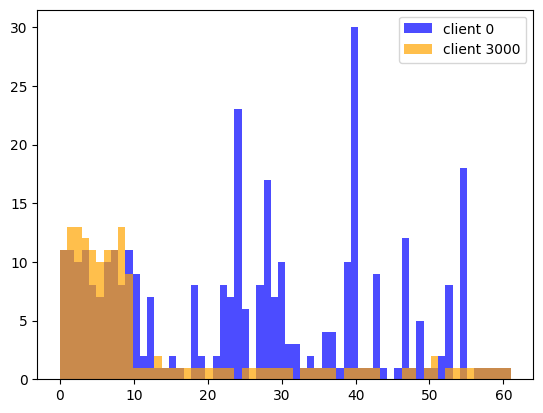

In [13]:
client_3000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "3000", data_dir=data_dir, name="train"
)
plt.hist(
    [int(x[1]) for x in client_0_dataset],
    bins=62,
    color="blue",
    alpha=0.7,
    label="client 0",
)
plt.hist(
    [int(x[1]) for x in client_3000_dataset],
    bins=62,
    color="orange",
    alpha=0.7,
    label="client 3000",
)
plt.legend()

### 2.3 Quantity skew
---

The last kind of heterogeneity we will discuss in detail is the _quantity skew_, which occurs when clients possess different numbers of samples. Last, but not least, it is the most investigated property that real FL datasets have. Also called "imbalancedness", it has been tackled using many techniques spanning from data manipulation to optimization algorithm design. Even if the literature regarding such techniques is quite broad, relative to FL being a new topic of research, there is still not any agreement about how to deal with imbalancedness. Often different solutions have different accuracy depending on the task and how imbalanced the FL dataset is.

Those of you that have well-trained observation skills may recall a plot in the last lab that spoiled this property. Now we'll try to get the global view of FEMNIST data from this perspective.


/tmp/ipykernel_602100/2496043336.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


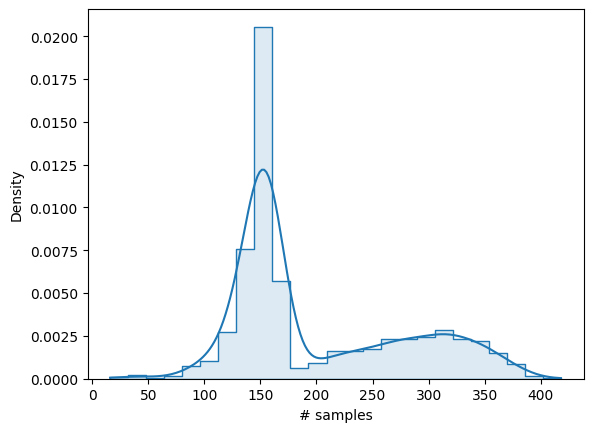

In [14]:
sns.histplot(
    alpha=0.15,
    legend=True,
    data=[
        len(
            FEMNIST(
                mapping=federated_partition / str(i), data_dir=data_dir, name="train"
            )
        )
        for i in range(3229)
    ],
    fill=True,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    common_bins=True,
    cbar=True,
    palette="dark",
)
plt.xlabel("# samples")
plt.show()

## 3. The behaviour of FL under data heterogeneity/creating heterogeneous partitions
---


### FEMNIST folder structure
---

By default, FEMNIST will be split as follows:

- `femnist`: the location of the relevant data
  - `client_data_mappings`: contains different partitions
    - `centralized`: mappings from writer_id -> `[image_path, label]` for the centralized dataset
    - `fed_natural`: mappings from writer_id -> `[image_path, label]` for the naturally federated dataset
  - `data`: contains the macro partitions between test, train, and val
    - `train`: contains the raw images---samples of the train set
    - `test`: contains the raw images---samples of the test set
    - `val`: contains the raw images---samples of the val set
- `femnist.tar.gz`: the compressed dataset

We will store client datasets in sequentially labelled folders within each partition and do all necessary remapping in python.


### Test sets for FL
---

Prior to constructing our centralized partition, it is necessary to discuss what a test set even means for FL.

A testing set can generally be either a **federated test set** or a **local test set**:

- A federated test set contains data representative of the entire federated network and is used to provide a form of centralized-like evaluation of the federated model. In production scenarios, this would be data that has been consensually gathered from a multitude of users and is legal/efficient to store on the server or clients which have been kept out of the training loop. For research purposes it can be constructed in one of the two following ways:
  - Take x% of data from all clients and save it separately.
  - Leave y% of clients utterly unavailable for federated training and use their data as a test/validation set. **This is the version we shall use during the lab for the federated test set.**
- A local test set is formed via data from a specific client which has not been seen during training. There are as many local test sets as there are clients. As such, they can be used to test the model on a specific client or to accumulate average statistics to determine its performance.


#### Class imbalancedness
---

We will start creating class imbalanced partitions. The most representative example, as often happens, is the extreme one. Thus, we are going to create a partition of the dataset in which each client possesses one class only. This aim sets one parameter for the creation of the current partition, but we need to choose also another parameter: the number of clients we want to create or the number of samples per client that we want to infer. These last are two antagonist parameters that describe the same thing. The larger the number of clients is, the lower the number of samples per client is.

Let's start by looking at how labels are distributed in the entire dataset (test set only), by treating the dataset as centralized.


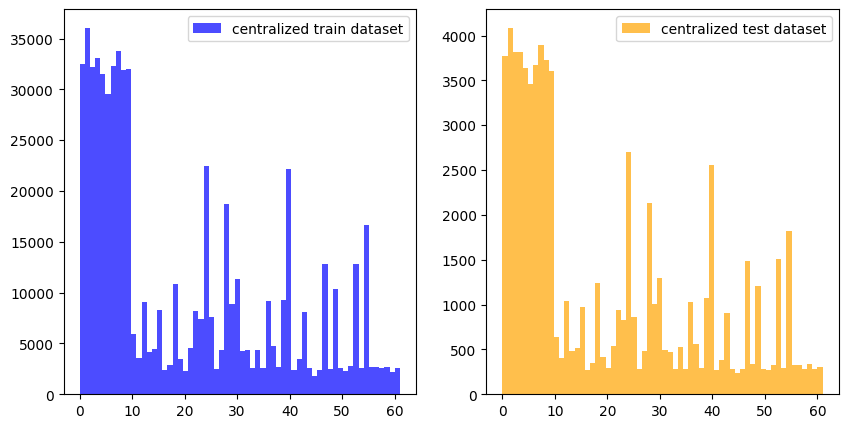

In [15]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="train"
)
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="test"
)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_histo = ax[0].hist(
    [int(x[1]) for x in centralized_train_dataset.data],
    bins=62,
    color="blue",
    alpha=0.7,
    label="centralized train dataset",
)
test_histo = ax[1].hist(
    [int(x[1]) for x in centralized_test_dataset.data],
    bins=62,
    color="orange",
    alpha=0.7,
    label="centralized test dataset",
)
ax[0].legend()
ax[1].legend()

Since the distribution is all but uniform, we need to make a further choice. We want to build a federation of 62 clients each of them having one class only. We want all the classes to be represented in the federation. Likewise, we also want FedAvg to treat equally all the clients in the federation. Thus, we will need to partition clients taking into account the population of the least represented class in both the `train` and the `test` set.


In [16]:
log(
    INFO,
    "The least represented class in the train set has %s samples",
    min(train_histo[0]),
)
log(
    INFO,
    "The least represented class in the test set has %s samples",
    min(test_histo[0]),
)
max_train_samples = int(min(train_histo[0]))
max_test_samples = int(min(test_histo[0]))

INFO flwr 2025-03-08 22:59:29,849 | 3870438806.py:1 | The least represented class in the train set has 1786.0 samples


2025-03-08 22:59:29 INFO     The least represented class in the train set has 1786.0 samples                 ]8;id=733173;file:///tmp/ipykernel_602100/3870438806.py\flwr]8;;\:]8;id=700576;file:///tmp/ipykernel_602100/3870438806.py#1\1]8;;\

INFO flwr 2025-03-08 22:59:29,854 | 3870438806.py:6 | The least represented class in the test set has 233.0 samples


                    INFO     The least represented class in the test set has 233.0 samples                   ]8;id=773371;file:///tmp/ipykernel_602100/3870438806.py\flwr]8;;\:]8;id=838929;file:///tmp/ipykernel_602100/3870438806.py#6\6]8;;\

Let's now create the function that creates the partition. We will stick to the folder structure the dataset has.


In [17]:
class_imbalanced_partition: Path = (
    dataset_dir / "client_data_mappings" / "class_imbalanced"
)
# class_imbalanced_partition.mkdir(parents=True, exist_ok=True)
# train_df = pd.read_csv(centralized_mapping / "train.csv")
# test_df = pd.read_csv(centralized_mapping / "test.csv")
# max_train_samples = 200
# max_test_samples = 50
# for i in range(62):
#     folder_path: Path = class_imbalanced_partition / str(i)
#     folder_path.mkdir(parents=True, exist_ok=True)

#     train_path: Path = folder_path / "train.csv"
#     test_path: Path = folder_path / "test.csv"

#     client_df = deepcopy(
#         train_df[train_df.label == i].sample(frac=1)[:max_train_samples]
#     ).reset_index()
#     client_df["client_id"] = i
#     client_df = client_df.drop(columns=["level_0"])
#     client_df.to_csv(train_path, index=False)
#     client_df = deepcopy(
#         test_df[test_df.label == i].sample(frac=1)[:max_test_samples]
#     ).reset_index()
#     client_df["client_id"] = i
#     client_df = client_df.drop(columns=["level_0"])
#     client_df.to_csv(test_path, index=False)

Here, we seed the initial model parameters to come from a partially trained model on the centralized dataset.


In [18]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[[str], FlowerClient] = (
    get_frank_flower_client_generator(
        model_generator=network_generator_cnn,
        partition_dir=centralized_partition,
        data_dir=data_dir,
    )
)
centralized_flower_client = centralized_flower_client_generator(str(0))
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 1000,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": None,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
initial_parameters: Parameters = ndarrays_to_parameters(trained_params)

INFO flwr 2025-03-08 22:59:29,883 | frank_flower_client.py:40 | cid: 0


                    INFO     cid: 0                                                                         ]8;id=370325;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=623333;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/centralized'), 'cid': 0, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac4d6b7e80>}


We also create the centralised evaluation function that will be executed by the server at the end of every round if requested.


In [19]:
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

INFO flwr 2025-03-08 22:59:48,266 | client_utils.py:463 | Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667


2025-03-08 22:59:48 INFO     Reduced federated test_set size from 28510 to a size of 1500 mean index:      ]8;id=614242;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/common/client_utils.py\flwr]8;;\:]8;id=767447;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/common/client_utils.py#463\463]8;;\
                             14726.628666666667                                                                    

Finally, the client generator function.


In [20]:
imbalanced_flower_client_generator: Callable[[str], FlowerClient] = (
    get_frank_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=class_imbalanced_partition,
    )
)

In [21]:
train_dataset_client_0 = imbalanced_flower_client_generator(str(1))._load_dataset(
    "train"
)
# [int(x[1]) for x in train_dataset_client_0.data]
print(train_dataset_client_0.target_transform)

INFO flwr 2025-03-08 22:59:48,286 | frank_flower_client.py:40 | cid: 1


                    INFO     cid: 1                                                                         ]8;id=402343;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=665713;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

<function to_tensor_transform at 0x74ac5e8b2e60>


Let's see how these clients look like.


INFO flwr 2025-03-08 22:59:48,299 | frank_flower_client.py:40 | cid: 0


                    INFO     cid: 0                                                                         ]8;id=410571;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=730983;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 22:59:48,349 | frank_flower_client.py:40 | cid: 1


                    INFO     cid: 1                                                                         ]8;id=956621;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=382597;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

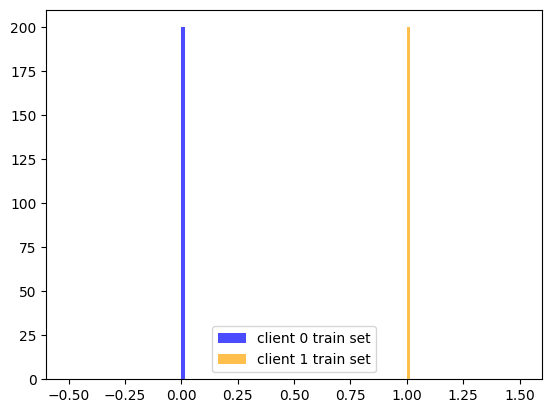

In [22]:
N_CLASSES = 62
train_dataset_client_0 = imbalanced_flower_client_generator(str(0))._load_dataset(
    "train"
)
plt.hist(
    [int(x[1]) for x in train_dataset_client_0.data],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
train_dataset_client_1 = imbalanced_flower_client_generator(str(1))._load_dataset(
    "train"
)
plt.hist(
    [int(x[1]) for x in train_dataset_client_1.data],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We will now create a wrapper for the strategy that will be used to extract the clients' model parameters obtained during the training for the next question.


In [23]:
class WrappedFrankWolfeSync(FrankWolfeSync):
    """Wrap the FrankWolfeSync strategy to store clients' models."""

    clients_models: ClassVar[dict[int, list[tuple[int, NDArrays]]]] = {}
    global_models: dict[int, list[tuple[int, NDArrays]]] = {}

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[tuple[ClientProxy, FitRes] | BaseException],
    ) -> tuple[Parameters | None, dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        # Call FedAvg original aggregate_fit, so that it handles the failures
        ret = super().aggregate_fit(server_round, results, failures)
        # Append clients' model parameters to the list
        self.clients_models[server_round] = [
            (i, parameters_to_ndarrays(fit_res.parameters))
            for i, (_, fit_res) in enumerate(results)
        ]
        # res is a Tuple containing 
        # parameters (Parameter Object), and 
        # dictionary containing loss values (avg, all)
        self.global_models[server_round] = parameters_to_ndarrays(ret[0])
        # Return the original return value
        return ret

In [24]:
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = 62
num_clients_per_round: int = 5
num_evaluate_clients: int = 5

strategy = WrappedFrankWolfeSync(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [25]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: imbalanced_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="imbalanced",
)

INFO flwr 2025-03-08 23:00:15,299 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


2025-03-08 23:00:15 INFO     Starting Flower simulation, config: ServerConfig(num_rounds=5,                ]8;id=614242;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py\flwr]8;;\:]8;id=767447;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py#149\149]8;;\
                             round_timeout=None)                                                                   

INFO flwr 2025-03-08 23:00:15,322 | server_returns_parameters.py:81 | Initializing global parameters


                    INFO     Initializing global parameters                                                 ]8;id=827969;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=377325;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#81\81]8;;\

INFO flwr 2025-03-08 23:00:15,329 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


                    INFO     Using initial parameters provided by strategy                                 ]8;id=798528;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=688156;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#273\273]8;;\

INFO flwr 2025-03-08 23:00:15,339 | server_returns_parameters.py:84 | Evaluating initial parameters


                    INFO     Evaluating initial parameters                                                  ]8;id=860291;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=666052;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#84\84]8;;\

100%|██████████| 47/47 [00:00<00:00, 50.31it/s]
INFO flwr 2025-03-08 23:00:16,292 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 62.05267310142517, {'accuracy': 0.596}


2025-03-08 23:00:16 INFO     initial parameters (loss, other metrics): 62.05267310142517, {'accuracy':      ]8;id=700576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=365011;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#87\87]8;;\
                             0.596}                                                                                

INFO flwr 2025-03-08 23:00:16,298 | server_returns_parameters.py:97 | FL starting


                    INFO     FL starting                                                                    ]8;id=838929;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=325949;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#97\97]8;;\

DEBUG flwr 2025-03-08 23:00:16,305 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 62)


                    DEBUG    fit_round 1: strategy sampled 5 clients (out of 62)                           ]8;id=893225;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=328967;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-08 23:00:16,317 | frank_flower_client.py:40 | cid: 42
INFO flwr 2025-03-08 23:00:16,317 | frank_flower_client.py:40 | cid: 1
INFO flwr 2025-03-08 23:00:16,325 | frank_flower_client.py:40 | cid: 53


                    INFO     cid: 42                                                                        ]8;id=633960;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=479364;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 23:00:16,328 | frank_flower_client.py:40 | cid: 22
INFO flwr 2025-03-08 23:00:16,331 | frank_flower_client.py:40 | cid: 38


                    INFO     cid: 1                                                                         ]8;id=574365;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=70569;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 53                                                                        ]8;id=811079;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=46011;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 22                                                                        ]8;id=649850;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=56447;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 38                                                                        ]8;id=206592;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=109670;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 1, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5c8d4ca0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 22, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74addcfe1570>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 42, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5d13a710>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 38, 

DEBUG flwr 2025-03-08 23:00:21,392 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures


2025-03-08 23:00:21 DEBUG    fit_round 1 received 5 results and 0 failures                                 ]8;id=837014;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=596302;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-08 23:00:21,404 | frank_flower_client.py:40 | cid: 42


                    INFO     cid: 42                                                                        ]8;id=640463;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=349796;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 23:00:21,420 | frank_flower_client.py:40 | cid: 1


                    INFO     cid: 1                                                                         ]8;id=576307;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=48058;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 23:00:21,435 | frank_flower_client.py:40 | cid: 22


                    INFO     cid: 22                                                                        ]8;id=322226;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=889643;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 23:00:21,452 | frank_flower_client.py:40 | cid: 38


                    INFO     cid: 38                                                                        ]8;id=554776;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=552299;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-08 23:00:21,467 | frank_flower_client.py:40 | cid: 53


                    INFO     cid: 53                                                                        ]8;id=52884;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=782619;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

/home/dawn/venvs/fed/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   2%|▎         | 5/200 [00:03<02:02,  1.59it/s]


perms_to_apply={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 5

100%|██████████| 47/47 [00:00<00:00, 56.17it/s]
INFO flwr 2025-03-09 13:19:29,814 | server_returns_parameters.py:120 | fit progress: (1, 253.3437623977661, {'accuracy': 0.050666666666666665}, 1852.7033819289645)


2025-03-09 13:19:29 INFO     fit progress: (1, 253.3437623977661, {'accuracy': 0.050666666666666665},      ]8;id=942449;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=25757;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             1852.7033819289645)                                                                   

DEBUG flwr 2025-03-09 13:19:29,821 | server_returns_parameters.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 62)


                    DEBUG    evaluate_round 1: strategy sampled 5 clients (out of 62)                      ]8;id=585503;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=837176;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#173\173]8;;\

INFO flwr 2025-03-09 13:19:29,829 | frank_flower_client.py:40 | cid: 51
INFO flwr 2025-03-09 13:19:29,835 | frank_flower_client.py:40 | cid: 33


                    INFO     cid: 51                                                                        ]8;id=70032;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=743184;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:29,845 | frank_flower_client.py:40 | cid: 31
INFO flwr 2025-03-09 13:19:29,850 | frank_flower_client.py:40 | cid: 34
INFO flwr 2025-03-09 13:19:29,853 | frank_flower_client.py:40 | cid: 48


                    INFO     cid: 33                                                                        ]8;id=178378;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=331396;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 31                                                                        ]8;id=998943;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=566682;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 34                                                                        ]8;id=581472;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=157243;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 48                                                                        ]8;id=923937;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=950761;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

DEBUG flwr 2025-03-09 13:19:29,922 | server_returns_parameters.py:187 | evaluate_round 1 received 0 results and 5 failures


                    DEBUG    evaluate_round 1 received 0 results and 5 failures                            ]8;id=163121;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=58673;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#187\187]8;;\

DEBUG flwr 2025-03-09 13:19:29,930 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 62)


                    DEBUG    fit_round 2: strategy sampled 5 clients (out of 62)                           ]8;id=675014;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=630152;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-09 13:19:29,942 | frank_flower_client.py:40 | cid: 40


                    INFO     cid: 40                                                                        ]8;id=142745;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=507580;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:29,951 | frank_flower_client.py:40 | cid: 29
INFO flwr 2025-03-09 13:19:29,963 | frank_flower_client.py:40 | cid: 22


                    INFO     cid: 29                                                                        ]8;id=265152;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=167485;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:29,970 | frank_flower_client.py:40 | cid: 24
INFO flwr 2025-03-09 13:19:29,976 | frank_flower_client.py:40 | cid: 4


                    INFO     cid: 22                                                                        ]8;id=412038;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=654695;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 24                                                                        ]8;id=974726;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=437809;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 4                                                                         ]8;id=652189;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=731544;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 22, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac441d9cc0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 29, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35baa200>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 40, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35ae1750>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 24,

DEBUG flwr 2025-03-09 13:19:34,972 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures


2025-03-09 13:19:34 DEBUG    fit_round 2 received 5 results and 0 failures                                 ]8;id=566195;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=629089;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-09 13:19:34,983 | frank_flower_client.py:40 | cid: 24


                    INFO     cid: 24                                                                        ]8;id=800315;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=988781;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:34,999 | frank_flower_client.py:40 | cid: 22


                    INFO     cid: 22                                                                        ]8;id=916451;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=376118;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:35,016 | frank_flower_client.py:40 | cid: 29


2025-03-09 13:19:35 INFO     cid: 29                                                                        ]8;id=461442;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=608319;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:35,031 | frank_flower_client.py:40 | cid: 40


                    INFO     cid: 40                                                                        ]8;id=653960;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=860199;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:35,046 | frank_flower_client.py:40 | cid: 4


                    INFO     cid: 4                                                                         ]8;id=404144;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=852609;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   2%|▎         | 5/200 [00:03<02:12,  1.47it/s]


perms_to_apply={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 5

100%|██████████| 47/47 [00:00<00:00, 90.03it/s]
INFO flwr 2025-03-09 13:19:39,600 | server_returns_parameters.py:120 | fit progress: (2, 387.0360794067383, {'accuracy': 0.042}, 1862.4893690610188)


2025-03-09 13:19:39 INFO     fit progress: (2, 387.0360794067383, {'accuracy': 0.042}, 1862.4893690610188) ]8;id=3017;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=359135;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\

DEBUG flwr 2025-03-09 13:19:39,606 | server_returns_parameters.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 62)


                    DEBUG    evaluate_round 2: strategy sampled 5 clients (out of 62)                      ]8;id=407641;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=146318;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#173\173]8;;\

INFO flwr 2025-03-09 13:19:39,614 | frank_flower_client.py:40 | cid: 5
INFO flwr 2025-03-09 13:19:39,620 | frank_flower_client.py:40 | cid: 53


                    INFO     cid: 5                                                                         ]8;id=609390;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=397184;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:39,622 | frank_flower_client.py:40 | cid: 59
INFO flwr 2025-03-09 13:19:39,623 | frank_flower_client.py:40 | cid: 17
INFO flwr 2025-03-09 13:19:39,626 | frank_flower_client.py:40 | cid: 31


                    INFO     cid: 53                                                                        ]8;id=699396;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=254830;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 59                                                                        ]8;id=751810;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=222790;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 17                                                                        ]8;id=290210;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=608142;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 31                                                                        ]8;id=996416;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=159951;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

DEBUG flwr 2025-03-09 13:19:39,705 | server_returns_parameters.py:187 | evaluate_round 2 received 0 results and 5 failures


                    DEBUG    evaluate_round 2 received 0 results and 5 failures                            ]8;id=675527;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=45323;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#187\187]8;;\

DEBUG flwr 2025-03-09 13:19:39,712 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 62)


                    DEBUG    fit_round 3: strategy sampled 5 clients (out of 62)                           ]8;id=959661;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=915662;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-09 13:19:39,719 | frank_flower_client.py:40 | cid: 41


                    INFO     cid: 41                                                                        ]8;id=975685;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=479779;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:39,735 | frank_flower_client.py:40 | cid: 35
INFO flwr 2025-03-09 13:19:39,736 | frank_flower_client.py:40 | cid: 31


                    INFO     cid: 35                                                                        ]8;id=829135;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=202170;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:39,738 | frank_flower_client.py:40 | cid: 18
INFO flwr 2025-03-09 13:19:39,759 | frank_flower_client.py:40 | cid: 1


                    INFO     cid: 31                                                                        ]8;id=679251;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=44361;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 41, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35a79f90>}


                    INFO     cid: 18                                                                        ]8;id=483350;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=747204;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 1                                                                         ]8;id=788887;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=328017;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 35, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35b69a50>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 18, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac441db100>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 31, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35299d50>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 1, 

DEBUG flwr 2025-03-09 13:19:44,596 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures


2025-03-09 13:19:44 DEBUG    fit_round 3 received 5 results and 0 failures                                 ]8;id=830699;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=660848;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-09 13:19:44,606 | frank_flower_client.py:40 | cid: 41


                    INFO     cid: 41                                                                        ]8;id=752617;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=16088;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:44,621 | frank_flower_client.py:40 | cid: 18


                    INFO     cid: 18                                                                        ]8;id=900605;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=203152;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:44,636 | frank_flower_client.py:40 | cid: 35


                    INFO     cid: 35                                                                        ]8;id=82091;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=167208;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:44,650 | frank_flower_client.py:40 | cid: 1


                    INFO     cid: 1                                                                         ]8;id=605526;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=624582;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:44,664 | frank_flower_client.py:40 | cid: 31


                    INFO     cid: 31                                                                        ]8;id=61729;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=451546;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   2%|▎         | 5/200 [00:03<02:22,  1.37it/s]


perms_to_apply={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 5

100%|██████████| 47/47 [00:00<00:00, 81.70it/s]
INFO flwr 2025-03-09 13:19:49,598 | server_returns_parameters.py:120 | fit progress: (3, 218.01121068000793, {'accuracy': 0.142}, 1872.4877532260143)


2025-03-09 13:19:49 INFO     fit progress: (3, 218.01121068000793, {'accuracy': 0.142},                    ]8;id=344246;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=892862;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             1872.4877532260143)                                                                   

DEBUG flwr 2025-03-09 13:19:49,605 | server_returns_parameters.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 62)


                    DEBUG    evaluate_round 3: strategy sampled 5 clients (out of 62)                      ]8;id=681029;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=693470;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#173\173]8;;\

INFO flwr 2025-03-09 13:19:49,615 | frank_flower_client.py:40 | cid: 35
INFO flwr 2025-03-09 13:19:49,621 | frank_flower_client.py:40 | cid: 29
INFO flwr 2025-03-09 13:19:49,622 | frank_flower_client.py:40 | cid: 30


                    INFO     cid: 35                                                                        ]8;id=397039;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=29037;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:49,630 | frank_flower_client.py:40 | cid: 47


                    INFO     cid: 29                                                                        ]8;id=957162;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=998391;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:49,636 | frank_flower_client.py:40 | cid: 12


                    INFO     cid: 30                                                                        ]8;id=978687;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=120655;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 47                                                                        ]8;id=547418;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=589473;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 12                                                                        ]8;id=963214;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=7368;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

DEBUG flwr 2025-03-09 13:19:49,695 | server_returns_parameters.py:187 | evaluate_round 3 received 0 results and 5 failures


                    DEBUG    evaluate_round 3 received 0 results and 5 failures                            ]8;id=509827;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=389630;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#187\187]8;;\

DEBUG flwr 2025-03-09 13:19:49,702 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 62)


                    DEBUG    fit_round 4: strategy sampled 5 clients (out of 62)                           ]8;id=796359;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=830177;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-09 13:19:49,710 | frank_flower_client.py:40 | cid: 2


                    INFO     cid: 2                                                                         ]8;id=839807;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=457226;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:49,722 | frank_flower_client.py:40 | cid: 49
INFO flwr 2025-03-09 13:19:49,724 | frank_flower_client.py:40 | cid: 42


                    INFO     cid: 49                                                                        ]8;id=182167;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=12601;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:49,725 | frank_flower_client.py:40 | cid: 20


                    INFO     cid: 42                                                                        ]8;id=198724;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=77048;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:49,744 | frank_flower_client.py:40 | cid: 0


                    INFO     cid: 20                                                                        ]8;id=670766;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=548391;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 0                                                                         ]8;id=232854;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=927964;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 42, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac45c110c0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 2, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5dfd40a0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 49, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac3c8e4850>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 20, 

DEBUG flwr 2025-03-09 13:19:54,755 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures


2025-03-09 13:19:54 DEBUG    fit_round 4 received 5 results and 0 failures                                 ]8;id=525813;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=195088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-09 13:19:54,766 | frank_flower_client.py:40 | cid: 2


                    INFO     cid: 2                                                                         ]8;id=548334;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=573227;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:54,781 | frank_flower_client.py:40 | cid: 0


                    INFO     cid: 0                                                                         ]8;id=969300;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=663594;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:54,796 | frank_flower_client.py:40 | cid: 20


                    INFO     cid: 20                                                                        ]8;id=919966;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=514409;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:54,811 | frank_flower_client.py:40 | cid: 42


                    INFO     cid: 42                                                                        ]8;id=814941;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=378305;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:54,826 | frank_flower_client.py:40 | cid: 49


                    INFO     cid: 49                                                                        ]8;id=732574;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=226580;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   2%|▎         | 5/200 [00:03<02:13,  1.47it/s]


perms_to_apply={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 5

100%|██████████| 47/47 [00:00<00:00, 91.78it/s]
INFO flwr 2025-03-09 13:19:59,397 | server_returns_parameters.py:120 | fit progress: (4, 393.32981061935425, {'accuracy': 0.09066666666666667}, 1882.2862460669712)


2025-03-09 13:19:59 INFO     fit progress: (4, 393.32981061935425, {'accuracy': 0.09066666666666667},      ]8;id=730650;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=995965;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             1882.2862460669712)                                                                   

DEBUG flwr 2025-03-09 13:19:59,404 | server_returns_parameters.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 62)


                    DEBUG    evaluate_round 4: strategy sampled 5 clients (out of 62)                      ]8;id=42868;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=711286;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#173\173]8;;\

INFO flwr 2025-03-09 13:19:59,412 | frank_flower_client.py:40 | cid: 3
INFO flwr 2025-03-09 13:19:59,420 | frank_flower_client.py:40 | cid: 25


                    INFO     cid: 3                                                                         ]8;id=86396;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=336984;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:59,421 | frank_flower_client.py:40 | cid: 44
INFO flwr 2025-03-09 13:19:59,437 | frank_flower_client.py:40 | cid: 33


                    INFO     cid: 25                                                                        ]8;id=588784;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=535943;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:59,439 | frank_flower_client.py:40 | cid: 2


                    INFO     cid: 44                                                                        ]8;id=706250;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=898652;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 33                                                                        ]8;id=33872;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=151734;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 2                                                                         ]8;id=650967;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=428586;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

DEBUG flwr 2025-03-09 13:19:59,499 | server_returns_parameters.py:187 | evaluate_round 4 received 0 results and 5 failures


                    DEBUG    evaluate_round 4 received 0 results and 5 failures                            ]8;id=862855;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=278182;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#187\187]8;;\

DEBUG flwr 2025-03-09 13:19:59,506 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 62)


                    DEBUG    fit_round 5: strategy sampled 5 clients (out of 62)                           ]8;id=629234;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=920534;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-09 13:19:59,514 | frank_flower_client.py:40 | cid: 24


                    INFO     cid: 24                                                                        ]8;id=841023;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=89943;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:59,526 | frank_flower_client.py:40 | cid: 30


                    INFO     cid: 30                                                                        ]8;id=269150;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=158619;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:59,544 | frank_flower_client.py:40 | cid: 21
INFO flwr 2025-03-09 13:19:59,555 | frank_flower_client.py:40 | cid: 4


                    INFO     cid: 21                                                                        ]8;id=917542;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=943352;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:19:59,566 | frank_flower_client.py:40 | cid: 23


                    INFO     cid: 4                                                                         ]8;id=159269;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=45845;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 23                                                                        ]8;id=825644;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=368800;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 24, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac5904e9b0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 30, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac35881630>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 4, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x74ac358250c0>}
MARKER
self.properties={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-federated/c2m3/scripts/../femnist/client_data_mappings/class_imbalanced'), 'cid': 21, 

DEBUG flwr 2025-03-09 13:20:04,479 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures


2025-03-09 13:20:04 DEBUG    fit_round 5 received 5 results and 0 failures                                 ]8;id=66007;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=766208;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-09 13:20:04,488 | frank_flower_client.py:40 | cid: 4


                    INFO     cid: 4                                                                         ]8;id=600058;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=967957;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:04,503 | frank_flower_client.py:40 | cid: 23


                    INFO     cid: 23                                                                        ]8;id=95019;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=209294;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:04,516 | frank_flower_client.py:40 | cid: 24


                    INFO     cid: 24                                                                        ]8;id=377866;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=748002;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:04,530 | frank_flower_client.py:40 | cid: 21


                    INFO     cid: 21                                                                        ]8;id=694072;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=954045;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:04,544 | frank_flower_client.py:40 | cid: 30


                    INFO     cid: 30                                                                        ]8;id=105311;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=310420;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   2%|▎         | 5/200 [00:03<02:06,  1.54it/s]


perms_to_apply={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 5

100%|██████████| 47/47 [00:00<00:00, 92.86it/s]
INFO flwr 2025-03-09 13:20:08,954 | server_returns_parameters.py:120 | fit progress: (5, 956.286922454834, {'accuracy': 0.007333333333333333}, 1891.843067224021)


2025-03-09 13:20:08 INFO     fit progress: (5, 956.286922454834, {'accuracy': 0.007333333333333333},       ]8;id=918070;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=304988;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             1891.843067224021)                                                                    

DEBUG flwr 2025-03-09 13:20:08,960 | server_returns_parameters.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 62)


                    DEBUG    evaluate_round 5: strategy sampled 5 clients (out of 62)                      ]8;id=943907;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=567303;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#173\173]8;;\

INFO flwr 2025-03-09 13:20:08,968 | frank_flower_client.py:40 | cid: 58
INFO flwr 2025-03-09 13:20:08,970 | frank_flower_client.py:40 | cid: 2
INFO flwr 2025-03-09 13:20:08,971 | frank_flower_client.py:40 | cid: 16


                    INFO     cid: 58                                                                        ]8;id=288872;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=36212;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:08,992 | frank_flower_client.py:40 | cid: 26


                    INFO     cid: 2                                                                         ]8;id=52334;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=980355;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

INFO flwr 2025-03-09 13:20:08,994 | frank_flower_client.py:40 | cid: 20


                    INFO     cid: 16                                                                        ]8;id=522883;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=674671;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 26                                                                        ]8;id=630561;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=393881;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

                    INFO     cid: 20                                                                        ]8;id=77243;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py\flwr]8;;\:]8;id=612852;file:///home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/flower/frank_flower_client.py#40\40]8;;\

DEBUG flwr 2025-03-09 13:20:09,046 | server_returns_parameters.py:187 | evaluate_round 5 received 0 results and 5 failures


2025-03-09 13:20:09 DEBUG    evaluate_round 5 received 0 results and 5 failures                            ]8;id=402253;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=772640;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#187\187]8;;\

INFO flwr 2025-03-09 13:20:09,055 | server_returns_parameters.py:150 | FL finished in 1891.9439837610116


                    INFO     FL finished in 1891.9439837610116                                             ]8;id=709106;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=642785;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#150\150]8;;\

INFO flwr 2025-03-09 13:20:09,061 | app.py:250 | app_fit: losses_distributed []


                    INFO     app_fit: losses_distributed []                                                ]8;id=133918;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=410490;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#250\250]8;;\

INFO flwr 2025-03-09 13:20:09,067 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 3.1387519984054277e-07, 'all': [(6, 1.7927003858238717e-08), (6, 3.2984015495747996e-09), (6, 0.0), (6, 1.548131191242419e-06), (6, 1.9402552481340152e-11)]}), (2, {'avg': 1.2495236583846362e-09, 'all': [(6, 6.150605543394268e-09), (6, 0.0), (6, 0.0), (6, 0.0), (6, 9.701274852891295e-11)]}), (3, {'avg': 1.056691653002669e-07, 'all': [(6, 8.517667422075492e-09), (6, 5.010475282081946e-07), (6, 9.701274043353673e-11), (6, 1.8644813025668155e-08), (6, 3.8805104962680304e-11)]}), (4, {'avg': 1.3775745916673928e-09, 'all': [(6, 0.0), (6, 2.77454920381374e-09), (6, 0.0), (6, 0.0), (6, 4.113323754523224e-09)]}), (5, {'avg': 1.0089326920222537e-10, 'all': [(6, 0.0), (6, 0.0), (6, 0.0), (6, 5.044663460111268e-10), (6, 0.0)]})]}


                    INFO     app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg':                  ]8;id=274273;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=346803;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#251\251]8;;\
                             3.1387519984054277e-07, 'all': [(6, 1.7927003858238717e-08), (6,                      
                             3.2984015495747996e-09), (6, 0.0), (6, 1.548131191242419e-06), (6,                    
                             1.9402552481340152e-11)]}), (2, {'avg': 1.2495236583846362e-09, 'all': [(6,           
                             6.150605543394268e-09), (6, 0.0), (6, 0.0), (6, 0.0), (6,                             
                             9.701274852891295e-11)]}), (3, {'avg': 1.056691653002669e-07, 'all': [(6,             
                             8.517667422075492e-09), (6, 5.010475282081946e-07), (6,                               
                             9.701274043353673e-11), (6, 1.8644813025668155e-08), (6,                              
                             3.8805104962680304e-11)]}), (4, {'avg': 1.3775745916673928e-09, 'all': [(6,           
                             0.0), (6, 2.77454920381374e-09), (6, 0.0), (6, 0.0), (6,                              
                             4.113323754523224e-09)]}), (5, {'avg': 1.0089326920222537e-10, 'all': [(6,            
                             0.0), (6, 0.0), (6, 0.0), (6, 5.044663460111268e-10), (6, 0.0)]})]}                   

INFO flwr 2025-03-09 13:20:09,093 | app.py:252 | app_fit: metrics_distributed {}


                    INFO     app_fit: metrics_distributed {}                                               ]8;id=746827;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=549130;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#252\252]8;;\

INFO flwr 2025-03-09 13:20:09,099 | app.py:253 | app_fit: losses_centralized [(0, 62.05267310142517), (1, 253.3437623977661), (2, 387.0360794067383), (3, 218.01121068000793), (4, 393.32981061935425), (5, 956.286922454834)]


                    INFO     app_fit: losses_centralized [(0, 62.05267310142517), (1, 253.3437623977661),  ]8;id=137104;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=364925;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#253\253]8;;\
                             (2, 387.0360794067383), (3, 218.01121068000793), (4, 393.32981061935425), (5,         
                             956.286922454834)]                                                                    

INFO flwr 2025-03-09 13:20:09,109 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.596), (1, 0.050666666666666665), (2, 0.042), (3, 0.142), (4, 0.09066666666666667), (5, 0.007333333333333333)]}


                    INFO     app_fit: metrics_centralized {'accuracy': [(0, 0.596), (1,                    ]8;id=686827;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=160139;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#254\254]8;;\
                             0.050666666666666665), (2, 0.042), (3, 0.142), (4, 0.09066666666666667), (5,          
                             0.007333333333333333)]}                                                               

We will now investigate how such a partition behaves in an FL setting. In particular, we will try to understand what happens to the global model and the clients' updates as the training progresses.


---

**Question 2 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. For each round, retrieve the clients' models and the global model using the appropriate attribute of the `WrappedFrankWolfeSync` strategy.
---


I added some code to WrappedFrankWolfeSync class to collect the weights outputted by aggregate_fit every round and store it in a dictionary. This dictionary is assigned to the global_models state of the WrappedFrankWolfeSync class.

In [26]:
# Dict(Round number -> List(Tuple(client index, weights)))
clientModelsByRound = strategy.clients_models
# Dict(Round number -> weights)
globalModelByRound = strategy.global_models

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def flatten(unevenWeights):
    """
    Flattens an (possibly uneven) NDArray into a single 1D vector.
    """
    return np.concatenate([item.flatten() for item in unevenWeights])

def cosineSimilarity(f1, f2):
    """
    Flattens 2 vectors to make them 1D, then
    computes their cosine similarity.
    """
    # f1 = flatten(vec1)
    # f2 = flatten(vec2)
    return np.dot(f1, f2) / np.linalg.norm(f1) / np.linalg.norm(f2)

def computeSimilarityMatrix(models):
    """
    Computes the cosine similarity matrix for a list of client model weights.

    First, flatten each model's weights into a 1D array.
    Then compute the cosine similarity between every pair of flattened models.
    Finally, stores the results in a matrix.

    Parameters:
        models (NDArray): List of trained models.

    Returns:
        similarityMatrix: 2D numpy array
        similarityMatrix(i, j) is similarity between the ith and jth model
    """
    flatModels = [flatten(model) for model in models]
    similarityMatrix = np.zeros((len(flatModels), len(flatModels)))
    for i in range(len(flatModels)):
        for j in range(len(flatModels)):
            assert len(flatModels[i]) == len(flatModels[j]), "Model vectors must be same length."
            similarityMatrix[i, j] = cosineSimilarity(flatModels[i], flatModels[j])
    return similarityMatrix

def kld(vec1, vec2):
    """
    Flattens 2 vectors to make them 1D, then
    computes their kl divergence.
    """
    # f1 = torch.softmax(torch.FloatTensor(flatten(vec1)), dim=0).numpy()
    # f2 = torch.softmax(torch.FloatTensor(flatten(vec2)), dim=0).numpy()
    f1 = flatten(vec1)
    f2 = flatten(vec2)
    return entropy(f1, f2)

def computeKLDivergence(models):
    flatModels = [flatten(model) for model in models]
    divergence = np.zeros((len(flatModels), len(flatModels)))
    for i in range(len(flatModels)):
        for j in range(len(flatModels)):
            assert len(flatModels[i]) == len(flatModels[j]), "Model vectors must be same length."
            divergence[i, j] = kld(flatModels[i], flatModels[j])
    return divergence

---
2. Inspect the models collected for each round as follows:
   - Extract the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from common.client_utils import get_activations_from_random_input`, give a motivation for the choice of the parameters of this function if you decide to use it)
   - Compute the pairwise cosine-similarity (you can use functions similar to those used in the previous Lab) between the values obtained in the previous step.
   - Plot the results of this computation in a confusion matrix. The confusion matrix will have the shape `n_clients_per_round`x`n_clients_per_round`.
   - Repeat the same procedure for computing and compare the pairwise KL divergence between the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from scipy.stats import entropy`).
---

In [28]:
from collections import OrderedDict

def copy_net(weights):
    """
    Takes the weights of a network as NDArray,
    creates a new CNN object with the same shape, 
    and fills in the weights.

    Parameters:
        weights (NDArray): Weights of target model to copy
    
    Returns:
        model (Net): CNN object with weights
    """
    network_generator_cnn = get_network_generator_cnn()
    model = network_generator_cnn()
    new_state_dict = OrderedDict(
        {
            k: torch.FloatTensor(v)
            for (k, v) in zip(
                model.state_dict().keys(),
                weights
            )
        }
    )
    model.load_state_dict(new_state_dict)
    return model

I used get_activations_from_random_input

Parameters:

net: I used the above function to make Net objects using each set of clientWeights. The Net object was passed in this argument.

device: "cpu". My machine is normal.

n_samples: 200. The default is around 100 but I wanted slightly more stability.

seed: 1337. I felt the seed value itself does not matter as long as it stays consistent.

In [ ]:
from c2m3.common.client_utils import get_activations_from_random_input

for roundId, l in clientModelsByRound.items():
    # activation values for one round
    activations = []
    labels = []
    for clientId, clientWeights in l:
        model = copy_net(clientWeights)
        activation = torch.softmax(
            torch.FloatTensor(
                get_activations_from_random_input(model, "cpu", 200)
            ),
            dim=0
        )
        activations.append(activation)
        labels.append(clientId)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(computeSimilarityMatrix(activations), annot=True, cmap="YlGnBu", ax=ax)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(f'Similarity for round {roundId}')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

The similarities of all clients' activations (or rather the activations of the CNNs populated with the clients' trained weights) **after applying the softmax function** turned out to be extremely high.

I was curious, so I also tried plotting out the similarities without applying the softmax function:

In [ ]:
from c2m3.common.client_utils import get_activations_from_random_input

for roundId, l in clientModelsByRound.items():
    # activation values for one round
    activations = []
    labels = []
    for clientId, clientWeights in l:
        model = copy_net(clientWeights)
        activation = get_activations_from_random_input(model, "cpu", 200)
        activations.append(activation)
        labels.append(clientId)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(computeSimilarityMatrix(activations), annot=True, cmap="YlGnBu", ax=ax)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(f'Similarity for round {roundId}')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

Here the similarities were quite low. Since we are calculating cosine similarity, the magnitude of the activation values has nothing to do with similarity. Further analysis below, but first I wrote code for the KL Divergence:

In [ ]:
from c2m3.common.client_utils import get_activations_from_random_input

for roundId, l in clientModelsByRound.items():
    # activation values for one round
    activations = []
    labels = []
    for clientId, clientWeights in l:
        model = copy_net(clientWeights)
        activation = torch.softmax(
            torch.FloatTensor(
                get_activations_from_random_input(model, "cpu", 200)
            ),
            dim=0
        )
        activations.append(activation)
        labels.append(clientId)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(computeKLDivergence(activations), annot=True, cmap="YlGnBu", ax=ax)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(f'KL Divergence for round {roundId}')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

---
3. Compare the confusion matrices obtained. What do you observe, and how does it compare with your expectations? Briefly discuss the results.
---

Since we are exploring the extreme case where the clients' datasets are extrmely different (only containing data from one class each), I would expect their trained weights to be extremely different as well. However the way the clients (or rather CNNs loaded with their weights) react to random data should be similar, because each client would be an "expert" in its own class. 

Hence for every client, its activation would indicate a high probability assigned to one class and near-zero probabilities to others. However the "expert" class is different for each client. This explains why the activations themselves are almost completely different across clients.

However, I noted that the softmax function actually makes the low probabilities more uniform and lowers the relative magnitude of the "expert" class's logit. See below, the peak logit value is only around 3 times that of the rest. This explains why the clients' softmaxxed activations are so similar.

In [ ]:
activations = []
labels = []
for clientId, clientWeights in clientModelsByRound[1]:
    model = copy_net(clientWeights)
    activation = torch.softmax(
        torch.FloatTensor(
            get_activations_from_random_input(model, "cpu", 200)
        ),
        dim=0
    )
    activations.append(activation)
    labels.append(clientId)
print(f'Smallest value is {activations[0][0]}')
print(f'Largest value is {activations[0][39]}')
print(activations)

#### LDA partitions
---

The most popular method for creating heterogeneous partitions from a centralized dataset in terms of class unbalancing is [Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA is a generative probabilistic model for collections of discrete data. The paper linked above provides all the theoretical details about the method.

The important detail for you to understand about LDA is that the `concentration` parameter controls the degree of heterogeneity in the distribution while `num_partitions` controls how many clients are generated following the specified distribution.

A `concentration=0` implies a completely heterogeneous distribution where each client may only contain examples from one class. Thus, if for a `concentration=0` we were to set the `num_partitions` argument to the number of classes we will get the same partitioning as the one we manually created above.

> **Important:** The LDA partitioning only approaches a fully i.i.d distribution when `concentration` tends towards $\infty$. The most appropriate value of the `concentration` to generate a completely i.i.d. partition is dataset dependent. Feel free to try out different values of `concentration` and `num_partitions` to see how the partitioning changes.


Let's create the partitions using LDA with `concentration=2.5` and `num_partitions=1000`. This will result in a non-i.i.d. partitioning.


In [33]:
N_TOTAL_CLIENTS = 1_000
concentration = 2.5
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)

Let's store the partitions in the folder structure we have been using so far.


In [34]:
lda_partition: Path = dataset_dir / "client_data_mappings" / "lda"
if lda_partition.exists():
    shutil.rmtree(str(lda_partition))
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({
        "client_id": [0] * len(train_set[0]),
        "sample_path": train_set[0],
        "sample_id": range(len(train_set[0])),
        "label": train_set[1],
    }).to_csv(train_path, index=False, mode="w")
    pd.DataFrame({
        "client_id": [0] * len(test_set[0]),
        "sample_path": test_set[0],
        "sample_id": range(len(test_set[0])),
        "label": test_set[1],
    }).to_csv(test_path, index=False, mode="w")

We instantiate a client generator function.


In [35]:
lda_flower_client_generator: Callable[[str], FlowerClient] = (
    get_frank_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=lda_partition,
    )
)

We can also plot two clients' labels distributions to see how different they are.


In [ ]:
N_CLASSES = 62
plt.hist(
    [
        int(x[1])
        for x in lda_flower_client_generator(str(0))._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
plt.hist(
    [
        int(x[1])
        for x in lda_flower_client_generator(str(2))._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We try now to run an FL simulation is such challenging setting.


In [37]:
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0

strategy = FrankWolfeSync(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [ ]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="frankwolfe_lda_example",
)

---

**Question 4 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Produce a set of LDA partitions with `concentration` in `[0.001, 0.1, 1e3]`.
---

In [39]:
def get_partition_path(concentration):
    return dataset_dir / "client_data_mappings" / f'lda_{concentration}'

def make_partition(concentration):
    """
    Creates training and testing partitions 
    given a single concentration value, then inserts
    them to the appropriate path.

    Parameter:
        concentration (int)
    
    Returns:
        lda_partition (String): The resulting path of the partition
    """
    N_TOTAL_CLIENTS = 1_000
    # Create partitions
    x = np.array([x[0] for x in centralized_train_dataset.data])
    y = np.array([x[1] for x in centralized_train_dataset.data])
    train_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=None,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=concentration,
        accept_imbalanced=True,
        seed=Seeds.DEFAULT,
    )
    x = np.array([x[0] for x in centralized_test_dataset.data])
    y = np.array([x[1] for x in centralized_test_dataset.data])
    test_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=dist,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=concentration,
        accept_imbalanced=True,
        seed=Seeds.DEFAULT,
    )
    
    lda_partition: Path = get_partition_path(concentration)
    if lda_partition.exists():
        shutil.rmtree(str(lda_partition))
    lda_partition.mkdir(parents=True, exist_ok=True)

    for i, (train_set, test_set) in enumerate(
        zip(train_clients_partitions, test_clients_partitions, strict=True)
    ):
        folder_path: Path = lda_partition / str(i)
        folder_path.mkdir(parents=True, exist_ok=True)

        train_path: Path = folder_path / "train.csv"
        test_path: Path = folder_path / "test.csv"

        pd.DataFrame({
            "client_id": [0] * len(train_set[0]),
            "sample_path": train_set[0],
            "sample_id": range(len(train_set[0])),
            "label": train_set[1],
        }).to_csv(train_path, index=False, mode="w")
        pd.DataFrame({
            "client_id": [0] * len(test_set[0]),
            "sample_path": test_set[0],
            "sample_id": range(len(test_set[0])),
            "label": test_set[1],
        }).to_csv(test_path, index=False, mode="w")

    return lda_partition

In [40]:
def get_LDA_client_generator(concentration):
    return get_frank_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=get_partition_path(concentration),
    )

In [41]:
def plot_LDA(concentration, ax=None):
    """
    (Adaptation of the given code)
    Plots distribution of LDA partition according to concentration
    """
    if ax is None:
        ax = plt.subplots()

    lda_flower_client_generator: Callable[[int], FlowerClient] = (
        get_LDA_client_generator(concentration)
    )

    N_CLASSES = 62
    ax.hist(
        [int(x[1]) for x in lda_flower_client_generator(0)._load_dataset("train").data],
        bins=N_CLASSES,
        color="blue",
        alpha=0.7,
        label="client 0 train set",
    )
    ax.hist(
        [int(x[1]) for x in lda_flower_client_generator(1)._load_dataset("train").data],
        bins=N_CLASSES,
        color="orange",
        alpha=0.7,
        label="client 1 train set",
    )
    ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, concentration in tqdm(enumerate([0.001, 0.1, 1e3])):
    make_partition(concentration)
    plot_LDA(concentration, ax=ax[i])

2. Train an FL setting for every partition you have produced using the same hyperparameter we used in the cell above, but with `num_clients_per_round=62` and `ServerConfig(num_rounds=1)`.
---

Use the configuration provided by the following cell.

> **IMPORTANT**: Be careful when using the strategy object. You must ensure that the different experiments will use the same initial parameters. Inspect `flwr.server.strategy.FedAvg` to understand how these are used.


In [43]:
# NOTE: We are using randomly initialized parameters here.
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
q4_initial_parameters: Parameters = ndarrays_to_parameters(
    get_model_parameters(seed_net_cnn)
)
# Set up experiment configuration
N_TOTAL_CLIENTS = 100
N_TOTAL_ROUNDS = 1
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.001,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 62
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FrankWolfeSync(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=q4_initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [44]:
def train_LDA(concentration):
    strategy = FrankWolfeSync(
        fraction_fit=sys.float_info.min,
        fraction_evaluate=sys.float_info.min,
        min_fit_clients=num_clients_per_round,
        min_evaluate_clients=num_evaluate_clients,
        min_available_clients=max(num_clients_per_round, num_evaluate_clients),
        on_fit_config_fn=_on_fit_config_fn,
        on_evaluate_config_fn=None,
        evaluate_fn=federated_evaluation_function,
        initial_parameters=deepcopy(q4_initial_parameters),
        accept_failures=False,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    )

    make_partition(concentration)

    params, hist = start_seeded_simulation(
        client_fn=lambda cid: get_LDA_client_generator(concentration)(
            cid
        ).to_client(),
        num_clients=num_total_clients,
        config=ServerConfig(num_rounds=1),
        strategy=strategy,
        name="frankwolfe_lda_example",
    )
    return params, hist

In [ ]:
record = {}
for concentration in [0.001, 0.1, 1e3]:
    record[concentration] = train_LDA(concentration)

3. Why do you think one-shot averaging works well for full i.i.d. data and not for very heterogeneous clients?
---

In an iid scenario, client data should be a representative sample of the entire dataset: in terms of feature and label distribution. Hence each local model is essentially training to solve the same problem. Even if there is no synchronisation between rounds (and there is one synchronisation event at the end), the model is likely to perform well.

In a very heterogenous scenario, models trained by clients are likely to converge to different local optima, reflecting the statistical properties (label distribution, feature distribution) of their specific datasets. They would hence benefit more from regular synchronisations.

## 4. FL Strategies tackling heterogeneity
---

The challenge of dealing with non-iidness in FL has been discussed extensively since the publication of the first paper about FL. Many approaches have been proposed, but still, the literature doesn't agree on a general approach or a rule of thumb. A natural method is to modify/extend FedAvg or develop another algorithm specifically oriented to mitigating heterogeneity. In some applications, augmenting data to make it more similar between clients is possible. Some works assume a small dataset that is shared between clients to serve as a reference.

Every time a new approach has been proposed, many related questions have arisen. It is no longer clear that treating all examples of all the clients equally make sense. Some works proposed limiting the contributions of data from any client in the federation. The notion of fairness has been introduced and defined in many ways in order to set up principles that could result in new approaches, for example emphasizing underperforming clients during aggregation. It is not even clear whether a single global model is the correct objective for FL---works related to this question gave birth to Personalised Federated Learning (PFL), a sub-branch of research.

We started to think that we should be able to turn the non-iid problem from a bug into a feature treated similarly to a task in MTL. The number of works that start with this perspective is however limited.

Even if FedAvg can partially mitigate heterogeneity, it is not working well in all situations, as we saw previously. From the many new algorithms that were introduced, it is worth mentioning: [FedProx](https://www.researchgate.net/profile/Anit-Sahu/publication/329734586_On_the_Convergence_of_Federated_Optimization_in_Heterogeneous_Networks/links/5c1bdd5e299bf12be38ee52d/On-the-Convergence-of-Federated-Optimization-in-Heterogeneous-Networks.pdf), [q-FedAvg](https://arxiv.org/abs/1905.10497), [SCAFFOLD](http://proceedings.mlr.press/v119/karimireddy20a.html). For a matter of time, we will now explore just one of these algorithms introduced for tackling the non-iid problem specifically. We chose FedProx since it is the simplest to demonstrate.


### FedProx
---

The Federated Proximal (FedProx) method was developed in the context of tuning and benchmarking FedAvg in a heterogeneous setting. The authors of FedAvg proposed carefully tuning the learning rate and the number of local epochs to increase the accuracy in such settings but turned out clear that something more was necessary. Based on the client's heterogeneity, local updates change the global model not only in different directions in the loss space but also at different rates. This phenomenon is called client divergence or drifting.

Using FedAvg we would like to have a different number of local epochs for each client based on its characteristics. Thus, heuristically setting the number of local updates is not always optimal, because clients are all different from each other. Limiting the number of local updates through a more flexible tool is beneficial. Thus, FedProx proposes to incorporate a term in the local objective function that penalizes big changes from the current model at the server. In each node $k$, instead of minimizing the local loss function $F_k$, the local solver tries to approximately minimize:

$\min_wh_w(w;w^t)=F_k(w)+\frac{\mu}{2}||w-w^t||^2$,

where $||w-w^t||^2$ is the new proximal term.

FedProx acts as FedAvg apart from the change in the local objective. This new objective enforces limited local model updates more explicitly than FedAvg. Using FedProx, it is no longer necessary to tune the number of local epochs for each client to minimize divergence.

We will now implement and test FedProx on the natural partition of FEMNIST. Implementing FedProx just involves modifying the local training function of our `FlowerRayClient`. We will then write the new function and build a new `client_generator` function that overwrites the relevant methods of our client.


In [46]:
def train_fedprox_femnist(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
    proximal_mu: float,
) -> float:
    """Train the network on the training set using FedProx.

    Parameters
    ----------
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.
        proximal_mu (float): parameter for the weight of the proximal term.

    Returns
    -------
        float: the final epoch mean train loss.
    """
    global_params: Module = deepcopy(net)
    global_params.requires_grad_(False)
    global_params_list = [val for _, val in global_params.state_dict().items()]
    net.train()
    running_loss, total = 0.0, 0
    for _ in tqdm(range(epochs)):
        running_loss = 0.0
        total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # NOTE: here comes the implementation of FedProx algorithm
            proximal_term = 0.0
            for local_weights, global_weights in zip(
                net.parameters(), global_params_list, strict=True
            ):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(data), labels) + (proximal_mu / 2) * proximal_term
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
    return running_loss / total


def _train_fedprox(
    self: FlowerClient, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
) -> float:
    return train_fedprox_femnist(
        net=net,
        train_loader=train_loader,
        epochs=int(config["epochs"]),
        device=self.device,
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"]),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        proximal_mu=float(config["proximal_mu"]),
    )


def get_fedprox_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
) -> Callable[[str], FlowerClient]:
    """Implement a wrapper function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    The clients generated will train using FedProx algorithm.

    Parameters
    ----------
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.

    Returns
    -------
        Callable[[str], WrappedClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            WrappedClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        client = FrankFlowerClient(
            cid=int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following line
        client._train = MethodType(_train_fedprox, client)
        return client

    return client_fn

In [47]:
torch.manual_seed(Seeds.DEFAULT)
N_TOTAL_CLIENTS = 1000
CONCENTRATION = 0.1
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
# Store partitions
lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
if lda_partition.exists():
    shutil.rmtree(str(lda_partition))
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({
        "client_id": [0] * len(train_set[0]),
        "sample_path": train_set[0],
        "sample_id": range(len(train_set[0])),
        "label": train_set[1],
    }).to_csv(train_path, index=False)
    pd.DataFrame({
        "client_id": [0] * len(test_set[0]),
        "sample_path": test_set[0],
        "sample_id": range(len(test_set[0])),
        "label": test_set[1],
    }).to_csv(test_path, index=False)

We are now able to train an FL setting using FedProx.


In [48]:
# NOTE: we are using here the `get_fedprox_flower_client_generator`
federated_fedprox_flower_client_generator: Callable[[str], FlowerClient] = (
    get_fedprox_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=lda_partition,
    )
)
N_TOTAL_ROUNDS = 5
# Set up experiment configuration
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.1,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
    "proximal_mu": 0.01,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FrankWolfeSync(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [ ]:
params_list, hist = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy,
    name="fedprox",
)

---

**Question 5 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Train the FL setting composed of LDA partitions with `concentration=1.0` using FedProx with values of `proximal_mu` in $\{10.0, 0.1, 1e-5\}$. Keep `num_clients_per_round=5` and `ServerConfig(num_rounds=10)`. Use the experimental configurations bellow.
2. Plot the norm of the pseudo-gradient (average delta between the updated models and models at the start of the round) and the loss (in two plots) for every `proximal_mu`. What do you observe, and how does it compare with your expectations? Briefly discuss the results.

---


In [50]:
# Copied from previous lab
def pseudoGradient(t, parameters_per_round):
    """
    Calculates the delta of model parameters applied
    at timestep t. 
    """
    return np.linalg.norm(flatten([
      layer_t - layer_t_next
      for layer_t, layer_t_next
      in zip(parameters_per_round[t][1], parameters_per_round[t + 1][1])
      ]))

In [ ]:
hist.metrics_distributed_fit['train_loss'][0]

In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[[str], FlowerClient] = (
    get_frank_flower_client_generator(
        model_generator=network_generator_cnn,
        partition_dir=centralized_partition,
        data_dir=data_dir,
    )
)
centralized_flower_client = centralized_flower_client_generator(0)
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 1000,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
q5_initial_parameters_pretrained = ndarrays_to_parameters(trained_params)

In [ ]:
N_TOTAL_CLIENTS = 1000
N_TOTAL_ROUNDS = 10
N_CLIENTS_PER_ROUND = 5
CONCENTRATION = 1.0
fig, ax = plt.subplots(1, 6, figsize=(18, 6))
# Set up experiment configuration
for round_num, proximal_mu in tqdm(list(enumerate([10.0, 0.1, 1e-5]))):
    train_config: dict[str, Any] = {
        "epochs": 5,
        "batch_size": 32,
        "client_learning_rate": 0.01,
        "weight_decay": 0.001,
        "num_workers": 0,
        "max_batches": None,
        # NOTE: This must be adjusted according to the requests
        "proximal_mu": proximal_mu,
    }

    def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
        """
        Generate the training configuration for a given server round.

        This function updates the global training configuration with the current server
        round and returns the updated configuration.

        Parameters
        ----------
        server_round : int
            The current round of training on the server.

        Returns
        -------
        dict[str, Scalar]
            The updated training configuration dictionary.
        """
        train_config.update({"server_round": server_round})
        return train_config

    num_total_clients = N_TOTAL_CLIENTS
    num_clients_per_round: int = N_CLIENTS_PER_ROUND
    num_evaluate_clients: int = 0
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
    # Set up strategy
    strategy = FrankWolfeSync(
        fraction_fit=sys.float_info.min,
        fraction_evaluate=sys.float_info.min,
        min_fit_clients=num_clients_per_round,
        min_evaluate_clients=num_evaluate_clients,
        min_available_clients=max(num_clients_per_round, num_evaluate_clients),
        on_fit_config_fn=_on_fit_config_fn,
        on_evaluate_config_fn=None,
        evaluate_fn=federated_evaluation_function,
        initial_parameters=deepcopy(q5_initial_parameters_pretrained),
        accept_failures=False,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    )

    # Create partitions
    x = np.array([x[0] for x in centralized_train_dataset.data])
    y = np.array([x[1] for x in centralized_train_dataset.data])
    train_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=None,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=CONCENTRATION,
        accept_imbalanced=True,
    )
    x = np.array([x[0] for x in centralized_test_dataset.data])
    y = np.array([x[1] for x in centralized_test_dataset.data])
    test_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=dist,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=CONCENTRATION,
        accept_imbalanced=True,
    )
    # Store partitions
    lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
    if lda_partition.exists():
        shutil.rmtree(str(lda_partition))
    lda_partition.mkdir(parents=True, exist_ok=True)

    for i, (train_set, test_set) in enumerate(
        zip(train_clients_partitions, test_clients_partitions, strict=True)
    ):
        folder_path: Path = lda_partition / str(i)
        folder_path.mkdir(parents=True, exist_ok=True)

        train_path: Path = folder_path / "train.csv"
        test_path: Path = folder_path / "test.csv"

        pd.DataFrame(
            {
                "client_id": [0] * len(train_set[0]),
                "sample_path": train_set[0],
                "sample_id": range(len(train_set[0])),
                "label": train_set[1],
            }
        ).to_csv(train_path, index=False)
        pd.DataFrame(
            {
                "client_id": [0] * len(test_set[0]),
                "sample_path": test_set[0],
                "sample_id": range(len(test_set[0])),
                "label": test_set[1],
            }
        ).to_csv(test_path, index=False)
    # Create the client generator
    fedprox_flower_client_generator: Callable[[int], FlowerClient] = (
        get_fedprox_flower_client_generator(
            model_generator=network_generator_cnn,
            data_dir=data_dir,
            partition_dir=lda_partition,
        )
    )

    params_list, hist = start_seeded_simulation(
        client_fn=lambda cid: federated_fedprox_flower_client_generator(
            cid
        ).to_client(),
        num_clients=N_TOTAL_CLIENTS,
        config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
        strategy=strategy,
        name="fedprox",
    )

    sns.lineplot(
        [pseudoGradient(t, params_list) for t, _ in params_list[:-1]],
        ax=ax[round_num * 2],
        errorbar=None,
    ).set_title(f"proximal_mu={proximal_mu} pseudo gradient norm")

    sns.lineplot(
        [losses['avg'] for (_, losses) in hist.metrics_distributed_fit['train_loss']],
        ax=ax[round_num * 2 + 1],
        errorbar=None,
    ).set_title(f"proximal_mu={proximal_mu} losses")

(c) 2025 Alexandru-Andrei Iacob, Lorenzo Sani
